In [1]:
import gzip
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Data Cleaning 

In [2]:
data = []

# userId, gender, sport, id, longitude, latitude, altitude, timestamp, url, heart rate, speed
with gzip.open('endomondoHR.json.gz') as f:
    for l in f:
        data.append(eval(l))

In [3]:
data2 = []

# userId, hydration, sport, ascent, descent, calories, duration, id, timestamp, distance, url, weather, gender
with gzip.open('endomondoMeta.json.gz') as f:
    for l in f:
        data2.append(eval(l))

In [4]:
dfHR = pd.DataFrame(data)
dfMeta = pd.DataFrame(data2)

In [5]:
dfHR.columns

Index(['speed', 'altitude', 'gender', 'heart_rate', 'id', 'url', 'userId',
       'timestamp', 'longitude', 'latitude', 'sport'],
      dtype='object')

In [6]:
dfMeta.columns

Index(['userId', 'hydration', 'sport', 'ascent', 'descent', 'calories',
       'duration', 'id', 'timestamp', 'distance', 'url', 'weather', 'gender'],
      dtype='object')

In [7]:
dfHR['id'].nunique(), dfMeta['id'].nunique()

(253020, 962190)

In [8]:
merged_df = pd.merge(dfHR, dfMeta, on='id')

In [9]:
merged_df.columns

Index(['speed', 'altitude', 'gender_x', 'heart_rate', 'id', 'url_x',
       'userId_x', 'timestamp_x', 'longitude', 'latitude', 'sport_x',
       'userId_y', 'hydration', 'sport_y', 'ascent', 'descent', 'calories',
       'duration', 'timestamp_y', 'distance', 'url_y', 'weather', 'gender_y'],
      dtype='object')

In [10]:
# check which columns are the same
print(f"gender_x and gender_y: {merged_df['gender_x'].equals(merged_df['gender_y'])}") 
print(f"sport_x and sport_y: {merged_df['sport_x'].equals(merged_df['sport_y'])}") 
print(f"userId_x and userId_y: {merged_df['userId_x'].equals(merged_df['userId_y'])}") 
print(f"url_x and url_y: {merged_df['url_x'].equals(merged_df['url_y'])}") 
print(f"timestamp_x and timestamp_y: {merged_df['timestamp_x'].equals(merged_df['timestamp_y'])}") 

gender_x and gender_y: True
sport_x and sport_y: True
userId_x and userId_y: True
url_x and url_y: True
timestamp_x and timestamp_y: False


Although `timestamp_x` and `timestamp_y` are not 'equal', they are actually the same time but represented in different ways. `timestamp_x` is a Unix timestamp (in seconds), while `timestamp_y` is ISO8601 formatted timestamp in UTC. We decided to drop `timestamp_y` as the Unix timestamp is easier to deal with.

In [11]:
# merge those that are the same
merged_df['gender'] = merged_df['gender_x'].combine_first(merged_df['gender_y'])
merged_df['sport'] = merged_df['sport_x'].combine_first(merged_df['sport_y'])
merged_df['userId'] = merged_df['userId_x'].combine_first(merged_df['userId_y'])

# rename timestamp_x to timestamp
merged_df = merged_df.rename(columns={'timestamp_x': 'timestamp'})

# drop unnecessary columns
merged_df = merged_df.drop(['gender_x', 'gender_y', 'sport_x', 'sport_y', 'userId_x', 'userId_y', 'url_x', 'url_y', 'timestamp_y'], axis=1)

In [12]:
merged_df.isna().sum() # check for NAs

speed         203360
altitude           0
heart_rate         0
id                 0
timestamp          0
longitude          0
latitude           0
hydration     252892
ascent           501
descent          509
calories         757
duration           5
distance         261
weather        58441
gender             0
sport              0
userId             0
dtype: int64

In [13]:
# hydration too many NAs
# weather don't know 
# heart rate --> average from list
# timestamp drop since duration already there
# longitude, latitude drop
# id not needed after merging

# drop altitude??
# drop gender?? 

merged_df = merged_df.drop(['hydration','weather', 'speed', 'longitude', 'latitude', 'id', 'altitude', 'gender'], axis=1)
merged_df

,heart_rate,timestamp,ascent,descent,calories,duration,distance,sport,userId
0,"[100, 111, 120, 119, 120, 116, 125, 128, 131, ...","[1408898746, 1408898754, 1408898765, 140889877...",423.000,428.0000,1562.000000,7587.375,53.884580,bike,10921915
1,"[100, 105, 111, 110, 108, 115, 126, 130, 132, ...","[1408221682, 1408221687, 1408221699, 140822170...",227.000,230.0000,908.000000,4439.025,32.606390,bike,10921915
2,"[99, 105, 113, 110, 109, 110, 108, 121, 116, 1...","[1407858459, 1407858466, 1407858478, 140785849...",336.000,360.0000,1138.000000,6462.950,45.689740,bike,10921915
3,"[99, 105, 113, 109, 112, 116, 116, 114, 114, 1...","[1407432042, 1407432048, 1407432056, 140743206...",245.000,241.0000,921.000000,4490.901,32.704800,bike,10921915
4,"[110, 113, 114, 116, 123, 126, 129, 135, 137, ...","[1406909434, 1406909436, 1406909437, 140690943...",90.000,108.0000,350.000000,1357.004,11.921040,bike (transport),10921915
...,...,...,...,...,...,...,...,...,...
253015,"[81, 82, 90, 99, 107, 116, 125, 133, 138, 138,...","[1315154632, 1315154633, 1315154888, 131515514...",0.000,0.0000,0.867924,4.560,0.005047,swimming,69
253016,"[103, 106, 108, 107, 107, 107, 107, 109, 112, ...","[1314372379, 1314372381, 1314372384, 131437238...",0.000,0.0000,NaN,1357.000,7.126500,bike,69
253017,"[139, 139, 140, 142, 144, 146, 148, 150, 151, ...","[1314153113, 1314153116, 1314153120, 131415312...",0.000,0.0000,646.000000,1790.630,5.466285,run,69
253018,"[118, 121, 124, 127, 131, 132, 133, 134, 134, ...","[1314150558, 1314150563, 1314150568, 131415057...",60.563,61.5244,1002.000000,2500.440,18.753252,bike,69


In [14]:
merged_df.describe()

,ascent,descent,calories,duration,distance,userId
count,2.525190e+05,2.525110e+05,2.522630e+05,2.530150e+05,252759.000000,2.530200e+05
mean,8.691797e+03,8.685054e+03,9.992215e+03,1.762712e+04,23.730715,4.619649e+06
std,4.273484e+06,4.273552e+06,4.277752e+06,1.122539e+06,60.468102,3.932878e+06
min,0.000000e+00,0.000000e+00,-8.141850e+02,0.000000e+00,-10.068440,6.900000e+01
25%,1.600000e+01,1.700000e+01,3.320000e+02,1.841000e+03,6.366995,1.477239e+06
50%,6.500000e+01,6.600000e+01,6.250000e+02,3.347000e+03,12.977510,3.411439e+06
75%,1.890000e+02,1.900000e+02,1.020000e+03,5.650333e+03,31.184000,7.178673e+06
max,2.147480e+09,2.147480e+09,2.147480e+09,2.603880e+08,26684.773440,1.548142e+07


In [15]:
merged_df

,heart_rate,timestamp,ascent,descent,calories,duration,distance,sport,userId
0,"[100, 111, 120, 119, 120, 116, 125, 128, 131, ...","[1408898746, 1408898754, 1408898765, 140889877...",423.000,428.0000,1562.000000,7587.375,53.884580,bike,10921915
1,"[100, 105, 111, 110, 108, 115, 126, 130, 132, ...","[1408221682, 1408221687, 1408221699, 140822170...",227.000,230.0000,908.000000,4439.025,32.606390,bike,10921915
2,"[99, 105, 113, 110, 109, 110, 108, 121, 116, 1...","[1407858459, 1407858466, 1407858478, 140785849...",336.000,360.0000,1138.000000,6462.950,45.689740,bike,10921915
3,"[99, 105, 113, 109, 112, 116, 116, 114, 114, 1...","[1407432042, 1407432048, 1407432056, 140743206...",245.000,241.0000,921.000000,4490.901,32.704800,bike,10921915
4,"[110, 113, 114, 116, 123, 126, 129, 135, 137, ...","[1406909434, 1406909436, 1406909437, 140690943...",90.000,108.0000,350.000000,1357.004,11.921040,bike (transport),10921915
...,...,...,...,...,...,...,...,...,...
253015,"[81, 82, 90, 99, 107, 116, 125, 133, 138, 138,...","[1315154632, 1315154633, 1315154888, 131515514...",0.000,0.0000,0.867924,4.560,0.005047,swimming,69
253016,"[103, 106, 108, 107, 107, 107, 107, 109, 112, ...","[1314372379, 1314372381, 1314372384, 131437238...",0.000,0.0000,NaN,1357.000,7.126500,bike,69
253017,"[139, 139, 140, 142, 144, 146, 148, 150, 151, ...","[1314153113, 1314153116, 1314153120, 131415312...",0.000,0.0000,646.000000,1790.630,5.466285,run,69
253018,"[118, 121, 124, 127, 131, 132, 133, 134, 134, ...","[1314150558, 1314150563, 1314150568, 131415057...",60.563,61.5244,1002.000000,2500.440,18.753252,bike,69


In [16]:
# convert heart_rate to np array
merged_df['heart_rate'] = merged_df['heart_rate'].apply(lambda x: np.array(x))
# calculate average heart rate
merged_df['avg_heart_rate'] = merged_df['heart_rate'].apply(lambda x: np.mean(x))

merged_df = merged_df.drop(['heart_rate'], axis=1)

In [17]:
# only keep rows with avg heart rate > 25 and avg heart rate <= 210
merged_df = merged_df[(merged_df['avg_heart_rate'] > 25) & (merged_df['avg_heart_rate'] <= 210)]

In [18]:
# only keep rows with calories >= 1 and calories <= 10000
merged_df = merged_df[(merged_df['calories'] >= 1) & (merged_df['calories'] <= 10000)]


In [19]:
# only keep rows with distance > 0 (miles) and distance <= 10000 
merged_df = merged_df[(merged_df['distance'] > 0) & (merged_df['distance'] <= 10000)]


In [20]:
# only keep rows with duration >= 60 (assuming seconds) and duration <= 86400 (1 day)
merged_df = merged_df[(merged_df['duration'] >= 60) & (merged_df['duration'] <= 86400)]

In [21]:
# only keep rows with ascent <= 10000
merged_df = merged_df[merged_df['ascent'] <= 10000]


In [22]:
# only keep rows with descent <= 10000
merged_df = merged_df[merged_df['descent'] <= 10000]

In [23]:
merged_df.describe()

,ascent,descent,calories,duration,distance,userId,avg_heart_rate
count,246401.000000,246401.000000,246401.000000,246401.000000,246401.000000,2.464010e+05,246401.000000
mean,171.771426,169.141469,805.481199,4383.019070,23.693091,4.598288e+06,138.873200
std,348.228031,326.752067,725.815817,3900.098578,28.396588,3.930080e+06,18.531548
min,0.000000,0.000000,1.000000,60.000000,0.000030,6.900000e+01,31.269231
25%,19.000000,20.000000,345.000000,1880.050000,6.520746,1.470078e+06,127.640000
50%,66.000000,67.400000,634.000000,3375.886000,13.090000,3.381703e+06,139.984000
75%,190.000000,191.000000,1027.000000,5670.758000,31.328211,7.122167e+06,151.330000
max,9974.000000,9966.000000,9948.980000,86398.000000,3764.960320,1.548142e+07,209.982000


In [24]:
# Either 1) set bike (transport) to just bike or 2) remove bike(transport) all together 
# merged_df['sport'] = merged_df['sport'].replace("bike (transport)", "bike")

In [25]:
# keep sports with counts > 10 ??
# sport_counts = merged_df['sport'].value_counts()
# filtered_sports = sport_counts[sport_counts >= 10].index
# merged_df = merged_df[merged_df['sport'].isin(filtered_sports)]

In [26]:
merged_df.isna().sum() # check for NAs

timestamp         0
ascent            0
descent           0
calories          0
duration          0
distance          0
sport             0
userId            0
avg_heart_rate    0
dtype: int64

In [27]:
merged_df['sport'].value_counts()

sport
run                        114468
bike                        95801
mountain bike               13409
bike (transport)            10232
walk                         3749
indoor cycling               2484
orienteering                 1195
core stability training      1015
cross-country skiing          943
skate                         496
roller skiing                 408
fitness walking               396
hiking                        352
kayaking                      254
weight training               214
circuit training              188
downhill skiing               133
rowing                        113
gymnastics                     91
elliptical                     75
soccer                         70
treadmill running              67
aerobics                       41
swimming                       40
snowshoeing                    32
yoga                           19
horseback riding               16
badminton                      15
basketball                     13
golf    

In [28]:
#merged_df.to_dict(orient='records') # to convert final df back to list of dicts 

## EDA

In [29]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 246401 entries, 0 to 253019
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   timestamp       246401 non-null  object 
 1   ascent          246401 non-null  float64
 2   descent         246401 non-null  float64
 3   calories        246401 non-null  float64
 4   duration        246401 non-null  float64
 5   distance        246401 non-null  float64
 6   sport           246401 non-null  object 
 7   userId          246401 non-null  int64  
 8   avg_heart_rate  246401 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 18.8+ MB


In [30]:
merged_df.describe()

,ascent,descent,calories,duration,distance,userId,avg_heart_rate
count,246401.000000,246401.000000,246401.000000,246401.000000,246401.000000,2.464010e+05,246401.000000
mean,171.771426,169.141469,805.481199,4383.019070,23.693091,4.598288e+06,138.873200
std,348.228031,326.752067,725.815817,3900.098578,28.396588,3.930080e+06,18.531548
min,0.000000,0.000000,1.000000,60.000000,0.000030,6.900000e+01,31.269231
25%,19.000000,20.000000,345.000000,1880.050000,6.520746,1.470078e+06,127.640000
50%,66.000000,67.400000,634.000000,3375.886000,13.090000,3.381703e+06,139.984000
75%,190.000000,191.000000,1027.000000,5670.758000,31.328211,7.122167e+06,151.330000
max,9974.000000,9966.000000,9948.980000,86398.000000,3764.960320,1.548142e+07,209.982000


In [31]:
merged_df

,timestamp,ascent,descent,calories,duration,distance,sport,userId,avg_heart_rate
0,"[1408898746, 1408898754, 1408898765, 140889877...",423.000,428.0000,1562.000,7587.375,53.884580,bike,10921915,152.650000
1,"[1408221682, 1408221687, 1408221699, 140822170...",227.000,230.0000,908.000,4439.025,32.606390,bike,10921915,147.710000
2,"[1407858459, 1407858466, 1407858478, 140785849...",336.000,360.0000,1138.000,6462.950,45.689740,bike,10921915,140.554000
3,"[1407432042, 1407432048, 1407432056, 140743206...",245.000,241.0000,921.000,4490.901,32.704800,bike,10921915,147.020000
4,"[1406909434, 1406909436, 1406909437, 140690943...",90.000,108.0000,350.000,1357.004,11.921040,bike (transport),10921915,167.154000
...,...,...,...,...,...,...,...,...,...
253013,"[1317828485, 1317828486, 1317828487, 131782848...",10.000,20.0000,292.000,720.000,2.790000,run,69,160.842000
253014,"[1317827731, 1317827732, 1317827733, 131782773...",10.000,0.0000,132.000,463.000,1.281724,run,69,131.558190
253017,"[1314153113, 1314153116, 1314153120, 131415312...",0.000,0.0000,646.000,1790.630,5.466285,run,69,157.656000
253018,"[1314150558, 1314150563, 1314150568, 131415057...",60.563,61.5244,1002.000,2500.440,18.753252,bike,69,146.320641


In [34]:
cont_features = ['ascent', 'descent', 'calories', 'duration', 'distance', 'avg_heart_rate']

/Users/garrettlam/miniconda3/envs/cse158/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/garrettlam/miniconda3/envs/cse158/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/garrettlam/miniconda3/envs/cse158/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/garrettlam/miniconda3/envs/cse158/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

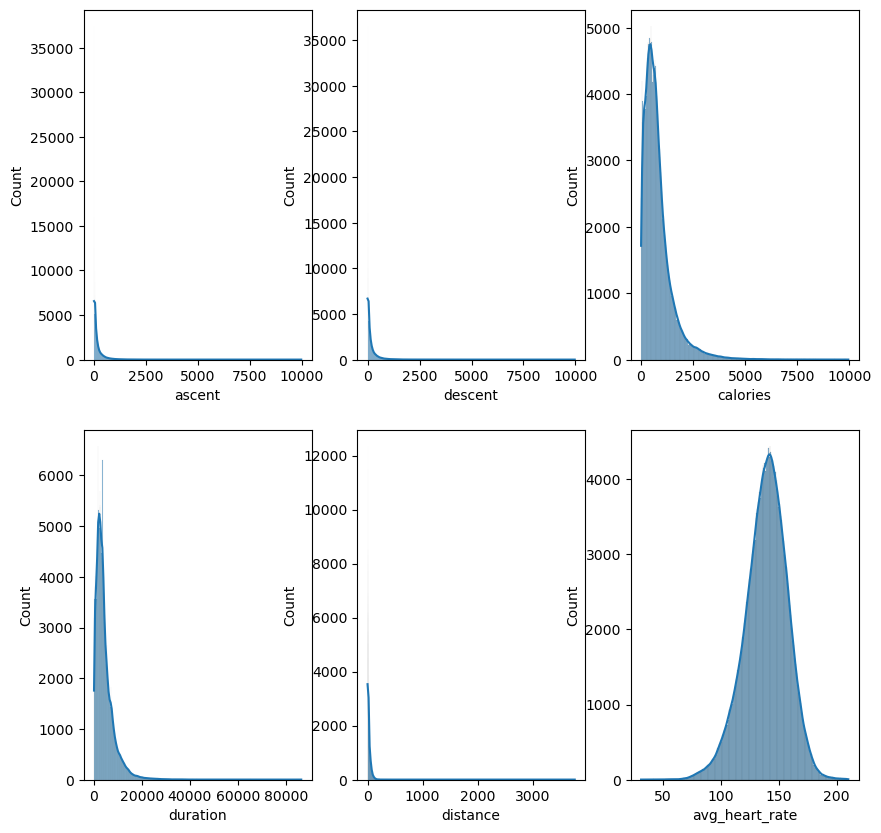

In [40]:
plt.figure(figsize=(10,10))
for i,feat in enumerate(cont_features):
    i+=1
    plt.subplot(2,3,i)
    sns.histplot(data=merged_df, x=feat, kde=True)

In [41]:
#sns.countplot(data=merged_df, x='sport', palette='deep')

In [ ]:
merged_df.describe().columns

Index(['ascent', 'descent', 'calories', 'duration', 'distance', 'userId',
       'avg_heart_rate'],
      dtype='object')